<a href="https://colab.research.google.com/github/jyotidabass/Grab-cut-for-tongue-image-extraction/blob/main/Grab_cut_for_tongue_image_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

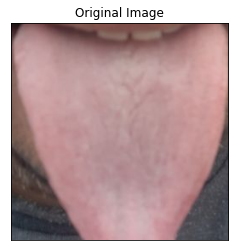

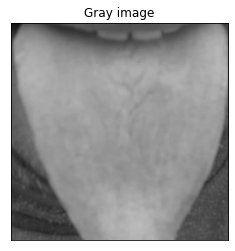

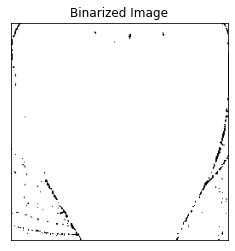

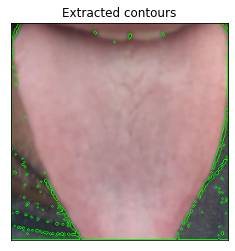

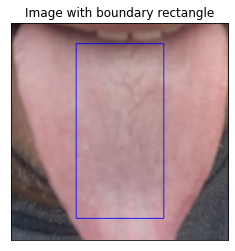

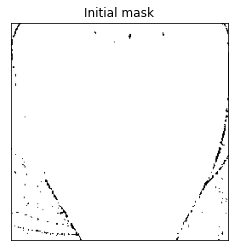

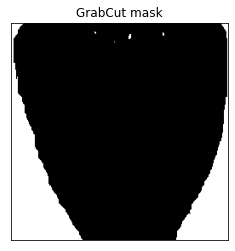

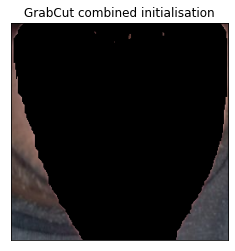

In [19]:

#%% Import all necessary libraries and data
from pathlib import Path

import cv2.cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

ROOT_FOLDER = '/content/drive/MyDrive'
IMAGES_FOLDER = '/content/drive/MyDrive/Two class'
OUTPUT_FOLDER = '/content/drive/MyDrive/Results'


def show_image(image, title=None):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.title(title)
    plt.show()


#%% Show original image
original_image = cv2.imread('/content/drive/MyDrive/Tongue_256/Test_256/16405043713943994520415122534059 - Abhishek Kumar.jpg')
show_image(original_image, "Original Image")


#%% Binarize input image
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
show_image(gray_image, "Gray image")

binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)
show_image(255 * binarized_image, "Binarized Image")

#%% Use OpenCV findContours method
contours, hierarchy = cv2.findContours(
    binarized_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)
contours_image = cv2.drawContours(original_image.copy(), contours, -1, (0, 255, 0), 1)
show_image(contours_image, "Extracted contours")

#%% Set GrabCut parameters
cv2.setRNGSeed(0)
number_of_iterations = 5

# Define boundary rectangle containing the foreground object
height, width, _ = original_image.shape
left_margin_proportion = 0.3
right_margin_proportion = 0.3
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

#%%
original_image_with_boundary_rectangle = cv2.rectangle(
    original_image.copy(),
    (int(width * left_margin_proportion), int(height * up_margin_proportion)),
    (
        int(width * (1 - right_margin_proportion)),
        int(height * (1 - down_margin_proportion)),
    ),
    (255, 0, 0),
    1,
)
show_image(original_image_with_boundary_rectangle, "Image with boundary rectangle")

#%% GrabCut initialized only with a rectangle

# Initialize mask image
mask = np.zeros((height, width), np.uint8)

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    img=original_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)


grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

#show_image(segmented_image, "GrabCut initialized with rectangle")

#%% GrabCut with initial mask

# Initialize the mask with known information
initial_mask = binarized_image.copy()
show_image(255 * initial_mask, "Initial mask")

mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[initial_mask == 0] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    original_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
show_image(255 * grabcut_mask, "GrabCut mask")


grabcut_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]
show_image(grabcut_image, "GrabCut combined initialisation")

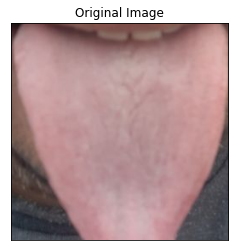

In [20]:
show_image(original_image, "Original Image")